In [1]:
"""
Implementation of the Transformer architecture for understanding
The code is largely based on Code is based on the repository: 
https://github.com/jadore801120/attention-is-all-you-need-pytorch
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import math
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pdb import set_trace

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Scaled Dot-Product Attention
$$\text{Attention}(Q,K,V)=\text{softmax}\left (\frac{QK^\top}{\sqrt{d_k}}V \right)$$

In [2]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, temperature, dropout=0.0):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, q, k, v, mask=None):
        attn = torch.matmul(q / self.temperature, k.transpose(-2,-1))
        if mask is not None: 
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = F.softmax(attn, dim=-1)
        output = self.dropout(torch.matmul(attn, v))
        return output, attn

## Multi-Head Attention
$$\text{MultiHead}(Q,K,V)=\text{Concat}(H_1,\dots,H_h) W^O$$

where $H_i=\text{Attention}(QW_i^Q,KW_i^K,VW_i^V)$.

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()
        
        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        assert self.d_k==self.d_v and self.d_k*self.n_head == self.d_model, "d_model must equal d_k * n_head and d_v * n_head"
        
        self.w_qs = nn.Linear(self.d_model, n_head*d_k, bias=False)
        self.w_ks = nn.Linear(self.d_model, n_head*d_k, bias=False)
        self.w_vs = nn.Linear(self.d_model, n_head*d_v, bias=False)
        self.fc = nn.Linear(n_head * self.d_v, self.d_model, bias=False)
        
        self.attention = ScaledDotProductAttention(temperature=self.d_k ** 0.5)
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(self.d_model, eps=1e-6)
    
    def forward(self, q, k, v, mask=None):
        batch_size = q.shape[0]
        len_q, len_k, len_v = q.shape[1], k.shape[1], v.shape[1]
        
        residual = q
        
        q = self.w_qs(q).view(batch_size, len_q, self.n_head, self.d_k)
        k = self.w_ks(k).view(batch_size, len_k, self.n_head, self.d_k)
        v = self.w_vs(v).view(batch_size, len_v, self.n_head, self.d_v)
        
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2) # Change shape from (b, n, h, d_k/v) to (b, h, n, d_k/v)
        
        if mask is not None:
            mask = mask.unsqueeze(1)
            
        attn_out, attn = self.attention(q, k, v, mask) # attn_out: (b, h, n, d_v), attn: (b, h, n, n)
        attn_out = attn_out.transpose(1, 2).contiguous().view(batch_size, len_q, -1) # Change shape from (b, h, n, d_v) to (b, n, h*d_v)
        
        mh_attn_out = self.fc(attn_out) # (b, n, d_model)
        
        return self.layer_norm(residual + self.dropout(mh_attn_out)), attn # (b, n, d_model), (b, h, n, n)


## Position-wise Feed-Forward Networks
$$\text{FFN}(x)=\max(0,xW_1+b_1)W_2+b_2$$

In [4]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.0):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        residual = x
        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        return self.layer_norm(residual + x)
        

## Encoder Layer
$$\text{EncoderLayer}(x)=\text{FFN}(\text{MultiHead}(x,x,x))$$

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_head, d_k, d_v, dropout=0.1):
        super().__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_ff, dropout=dropout)
    
    def forward(self, x, slf_attn_mask=None):
        mh_attn_out, mh_att = self.slf_attn(x, x, x, slf_attn_mask)
        return self.pos_ffn(mh_attn_out), mh_att
        

## Decoder Layer
$$\text{DecoderLayer}(x, e) = \text{FFN}(\text{MultiHead}(\text{MultiHead}(x,x,x),e,e))$$

where $e$ is the encoder output.

In [6]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_head, d_k, d_v, dropout=0.1):
        super().__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_ff, dropout=dropout)
        
    def forward(self, dec_input, enc_output, slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        return dec_output, dec_slf_attn, dec_enc_attn

## Positional Encoding
$$\text{PE}(pos, i)=\begin{cases}sin(pos/10000^{i/d_{model}}) & \text{if } i \text{ is even}\\\cos(pos/10000^{i/d_{model}}) & \text{otherwise}\end{cases}$$

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, n_position=200):
        super().__init__()
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_model)) # not a parameter
        
    def _get_sinusoid_encoding_table(self, n_position, d_model):
        pe = torch.zeros(n_position, d_model)
        position = torch.arange(0, n_position).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        return torch.FloatTensor(pe)
    
    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()
    
    def visualize(self):
        plt.title("Positional Encoding Visualization")
        plt.imshow(self.pos_table.squeeze(), cmap='Blues')
        plt.ylabel('Position')
        plt.xlabel('Dimension')
        plt.show()


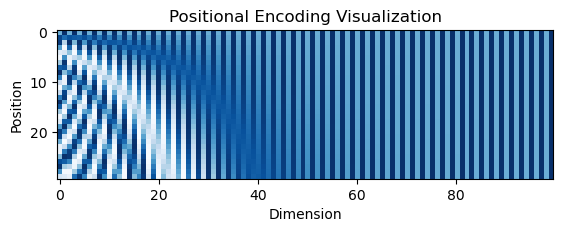

In [8]:
PositionalEncoding(100, 30).visualize()

## Encoder
$$\text{Encoder}(x) = \text{EncoderLayer}_N(\dots(\text{EncoderLayer}_1(x+\text{pe}(x))))$$

In [9]:
class Encoder(nn.Module):
    def __init__(self, n_src_vocab, d_word_vec, n_layers, n_head, 
                 d_k, d_v, d_model, d_ff, pad_idx, dropout=0.1, 
                 n_position=200, scale_emb=False):
        super().__init__()
        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_ff, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model
        
    def forward(self, src_seq, src_mask, return_attns=False):
        enc_slf_attn_list = []
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)
        
        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []
            
        if return_attns:
            return enc_output, enc_slf_attn_list
        return enc_output,

## Decoder
$$\text{Decoder}(x)=\text{DecoderLayer}_N(\dots (\text{DecoderLayer}_1(x+\text{pe}(x))))$$

In [10]:
class Decoder(nn.Module):
    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_ff, pad_idx, n_position=200, dropout=0.1, scale_emb=False):

        super().__init__()

        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_ff, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model
        
    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []

        # -- Forward
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []

        if return_attns:
            return dec_output, dec_slf_attn_list, dec_enc_attn_list
        return dec_output,


## Transformer

In [11]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)

def get_subsequent_mask(seq):
    ''' For masking out the subsequent info. '''
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask

class Transformer(nn.Module):
    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=512, d_model=512, d_ff=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1, n_position=200,
            trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True,
            scale_emb_or_prj='prj'):
        super().__init__()
        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx
        
        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model
        
        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_ff=d_ff,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)
        
        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_ff=d_ff,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, scale_emb=scale_emb)
        
        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)
        
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 
        
        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'
        
        # In our model, we share the same weight matrix between 
        # the two embedding layers and the pre-softmax linear transformation
        if trg_emb_prj_weight_sharing:
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight
        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight
            
    def forward(self, src_seq, trg_seq):
        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, *_ = self.encoder(src_seq, src_mask)
        dec_output, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5
        
        return seq_logit.view(-1, seq_logit.size(2))
#         return seq_logit, enc_output, dec_output
    

## Model Training for Copy-Task

#### Copy-task data generator

In [12]:
def data_gen(n_vocab, n_words, batch_size, n_batch, pad_idx=0, bos_idx=1, eos_idx=2):
    "Generate random data for a src-tgt copy task."
    data = []
    for i in range(n_batch):
        batch = torch.randint(3, n_vocab, size=(batch_size, n_words))
        batch[:, 0] = bos_idx
        eos_pos = torch.randint(1,n_words,(batch_size,))
        for j, row in enumerate(batch):
            row[eos_pos[j]] = eos_idx
            row[eos_pos[j]+1:] = pad_idx
        src = batch.requires_grad_(False).clone().detach()
        trg = batch.requires_grad_(False).clone().detach()
        data.append((src, trg))
    return data

In [13]:
data_gen(10, 10, 1, 1)

[(tensor([[1, 6, 3, 5, 4, 5, 9, 6, 7, 2]]),
  tensor([[1, 6, 3, 5, 4, 5, 9, 6, 7, 2]]))]

#### Loss function

In [14]:
def compute_loss(pred, label, pad_idx, smoothing=False):
    if smoothing:
        eps = 0.1
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, label.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = label.ne(pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, label, ignore_index=pad_idx, reduction='sum')
    return loss

def compute_performance(pred, label, pad_idx):
    pred = pred.max(-1)[1]
    non_pad_mask = label.ne(pad_idx)
    n_correct = pred.eq(label).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()
    return n_correct, n_word

#### Learning rate scheduling
$$lr = d^{-0.5}_{model} \cdot \min (step\_num^{-0.5}, step\_num \cdot warmup\_step^{-1.5})$$

In [15]:
class ScheduledOptim():
    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0
    
    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()
    
    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [16]:
n_vocab = 5
n_words = 5
d_model = 128
n_batch = 20
batch_size = 48
n_layers, n_head = 6, 8, 
d_k, d_v = d_model//n_head, d_model//n_head

pad_idx = 0
bos_idx = 1
eos_idx = 2

n_warmup_steps = 1000
n_epoch = 10

# Model
model = Transformer(
    n_src_vocab=n_vocab, n_trg_vocab=n_vocab, 
    src_pad_idx=pad_idx, trg_pad_idx=pad_idx,
    d_word_vec=d_model, d_model=d_model, d_ff=d_model*4,
    n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v)

# Optimizer
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09)
optimizer = ScheduledOptim(optimizer, 1.0, d_model, n_warmup_steps)

# Device
device = "cpu"

# Data
train_data = data_gen(n_vocab, n_words, batch_size, n_batch)
val_data = data_gen(n_vocab, n_words, batch_size, n_batch)

def train_epoch(model, train_data, optimizer, device, smoothing):
    model.train()
    total_loss, n_word_total, n_word_correct = 0, 0, 0 
    
    for src_seq, trg_seq in train_data:
        src_seq = src_seq.to(device)
        trg_seq = trg_seq.to(device)[:,1:]
        optimizer.zero_grad()
        pred = model(src_seq, trg_seq)
        label = trg_seq.contiguous().view(-1)
        loss = compute_loss(pred, label, pad_idx, smoothing=smoothing)
        loss.backward()
        optimizer.step_and_update_lr()
        n_correct, n_word = compute_performance(pred, label, pad_idx)
        n_word_correct += n_correct
        n_word_total += n_word
        
        total_loss += loss.item()
        
    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy

def eval_epoch(model, val_data, device):
    model.eval()
    total_loss, n_word_total, n_word_correct = 0, 0, 0
    
    with torch.no_grad():
        for src_seq, trg_seq in val_data:
            src_seq = src_seq.to(device)
            trg_seq = trg_seq.to(device)[:,1:]
            pred = model(src_seq, trg_seq)
            label = trg_seq.contiguous().view(-1)
            loss = compute_loss(pred, label, pad_idx, smoothing=False)
            n_correct, n_word = compute_performance(pred, label, pad_idx)
            n_word_correct += n_correct
            n_word_total += n_word
            total_loss += loss.item()
    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy

def train(model, optimizer, device):
    print("              Train loss Val loss   Train acc. Val acc.   lr")
    for epoch in range(n_epoch):
        train_loss, train_acc = train_epoch(model, train_data, optimizer, device, smoothing=False)
        validation_loss, validation_acc = eval_epoch(model, val_data, device)
        lr = optimizer._optimizer.param_groups[0]['lr']
        print(f'[ Epoch {epoch} ]', end=" ")
        print(f"{train_loss:10.6f} {validation_loss:10.6f} {train_acc:10.6f} {validation_acc:10.6f} {lr: 10.6f}")

train(model, optimizer, device)

              Train loss Val loss   Train acc. Val acc.   lr
[ Epoch 0 ]   1.492306   1.338141   0.277318   0.398010   0.000056
[ Epoch 1 ]   1.304219   1.233670   0.417219   0.505804   0.000112
[ Epoch 2 ]   1.216633   1.140867   0.498758   0.525290   0.000168
[ Epoch 3 ]   1.093709   0.856844   0.600993   0.860697   0.000224
[ Epoch 4 ]   0.807067   0.608345   0.856374   0.941957   0.000280
[ Epoch 5 ]   0.621962   0.499438   0.951573   1.000000   0.000335
[ Epoch 6 ]   0.514788   0.449110   0.988825   1.000000   0.000391
[ Epoch 7 ]   0.455346   0.403053   0.997517   1.000000   0.000447
[ Epoch 8 ]   0.404644   0.357064   0.998344   1.000000   0.000503
[ Epoch 9 ]   0.359699   0.312538   0.997517   1.000000   0.000559


## Copy-task Translation with Beam Search

In [17]:
class Translator(nn.Module):
    def __init__(
            self, model, beam_size, max_seq_len,
            src_pad_idx, trg_pad_idx, trg_bos_idx, trg_eos_idx):
        super().__init__()
        
        self.alpha = 0.7
        self.beam_size = beam_size
        self.max_seq_len = max_seq_len
        self.src_pad_idx = src_pad_idx
        self.trg_bos_idx = trg_bos_idx
        self.trg_eos_idx = trg_eos_idx
        
        self.model = model
        self.model.eval()
        
        self.register_buffer('init_seq', torch.LongTensor([[trg_bos_idx]]))
        self.register_buffer(
            'blank_seqs', 
            torch.full((beam_size, max_seq_len), trg_pad_idx, dtype=torch.long))
        self.blank_seqs[:, 0] = self.trg_bos_idx
        self.register_buffer(
            'len_map', 
            torch.arange(1, max_seq_len + 1, dtype=torch.long).unsqueeze(0))
        
    def _get_init_state(self, src_seq, src_mask):
        beam_size = self.beam_size
        enc_output, *_ = self.model.encoder(src_seq, src_mask)
        dec_output = self._model_decode(self.init_seq, enc_output, src_mask)
        
        best_k_probs, best_k_idx = dec_output[:, -1, :].topk(beam_size)
        
        scores = torch.log(best_k_probs).view(beam_size)
        gen_seq = self.blank_seqs.clone().detach()
        gen_seq[:, 1] = best_k_idx[0]
        enc_output = enc_output.repeat(beam_size, 1, 1)
        return enc_output, gen_seq, scores
    
    def _model_decode(self, trg_seq, enc_output, src_mask):
        trg_mask = get_subsequent_mask(trg_seq)
        dec_output, *_ = self.model.decoder(trg_seq, trg_mask, enc_output, src_mask)
        return F.softmax(self.model.trg_word_prj(dec_output), dim=-1)

    def _get_the_best_score_and_idx(self, gen_seq, dec_output, scores, step):
        assert len(scores.size()) == 1
        beam_size = self.beam_size

        # Get k candidates for each beam, k^2 candidates in total.
        best_k2_probs, best_k2_idx = dec_output[:, -1, :].topk(beam_size)

        # Include the previous scores.
        scores = torch.log(best_k2_probs).view(beam_size, -1) + scores.view(beam_size, 1)

        # Get the best k candidates from k^2 candidates.
        scores, best_k_idx_in_k2 = scores.view(-1).topk(beam_size)
 
        # Get the corresponding positions of the best k candidiates.
        best_k_r_idxs, best_k_c_idxs = torch.div(best_k_idx_in_k2, beam_size, rounding_mode="floor"), best_k_idx_in_k2 % beam_size
#         best_k_r_idxs, best_k_c_idxs = best_k_idx_in_k2 // beam_size, best_k_idx_in_k2 % beam_size
        best_k_idx = best_k2_idx[best_k_r_idxs, best_k_c_idxs]

        # Copy the corresponding previous tokens.
        gen_seq[:, :step] = gen_seq[best_k_r_idxs, :step]
        # Set the best tokens in this beam search step
        gen_seq[:, step] = best_k_idx

        return gen_seq, scores

    def translate(self, src_seq):
        assert src_seq.size(0) == 1
        src_pad_idx, trg_eos_idx = self.src_pad_idx, self.trg_eos_idx 
        max_seq_len, beam_size, alpha = self.max_seq_len, self.beam_size, self.alpha 
        
        with torch.no_grad():
            src_mask = get_pad_mask(src_seq, src_pad_idx)
            enc_output, gen_seq, scores = self._get_init_state(src_seq, src_mask)
            
            ans_idx = 0
            for step in range(2, max_seq_len): 
                dec_output = self._model_decode(gen_seq[:, :step], enc_output, src_mask)
                gen_seq, scores = self._get_the_best_score_and_idx(gen_seq, dec_output, scores, step)
                eos_locs = gen_seq == trg_eos_idx  
                seq_lens, _ = self.len_map.masked_fill(~eos_locs, max_seq_len).min(1)
                if (eos_locs.sum(1) > 0).sum(0).item() == beam_size:
                    _, ans_idx = scores.div(seq_lens.float() ** alpha).max(0)
                    ans_idx = ans_idx.item()
                    break
        return gen_seq[ans_idx][:seq_lens[ans_idx]]

In [18]:
translator = Translator(model, beam_size=1, max_seq_len=n_words, 
           src_pad_idx=pad_idx, trg_pad_idx=pad_idx,
           trg_bos_idx=bos_idx, trg_eos_idx=eos_idx)
test_sentence = data_gen(n_vocab, n_words, 1, 1)[0]
print(f"Test sentence: {test_sentence[0]}")
print(f"Model prediction: {translator.translate(test_sentence[0])}")


Test sentence: tensor([[1, 4, 2, 0, 0]])
Model prediction: tensor([1, 4, 4, 4, 4])
